# 19기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
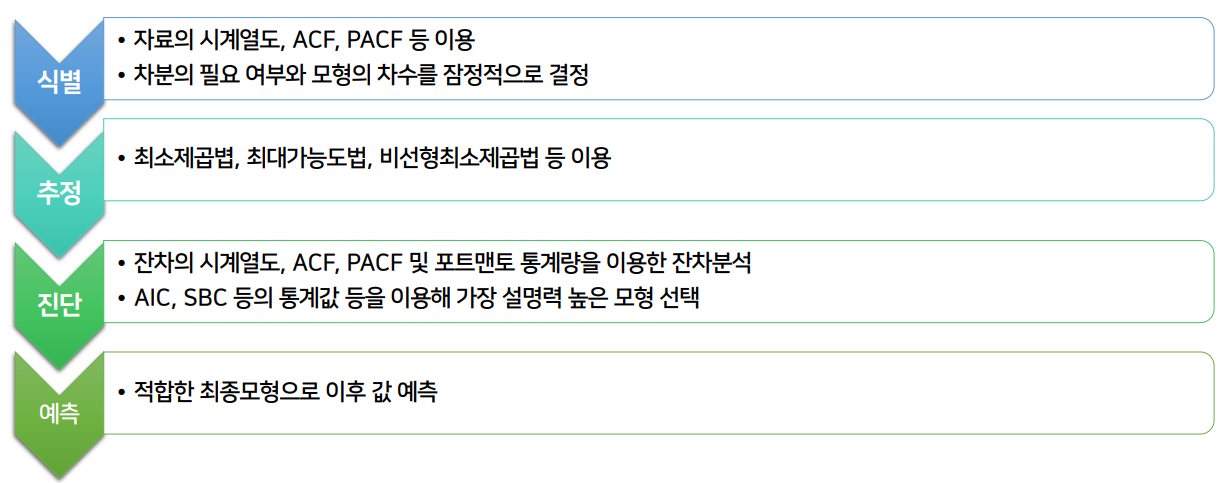

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [137]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 

## 데이터 불러오기

In [28]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


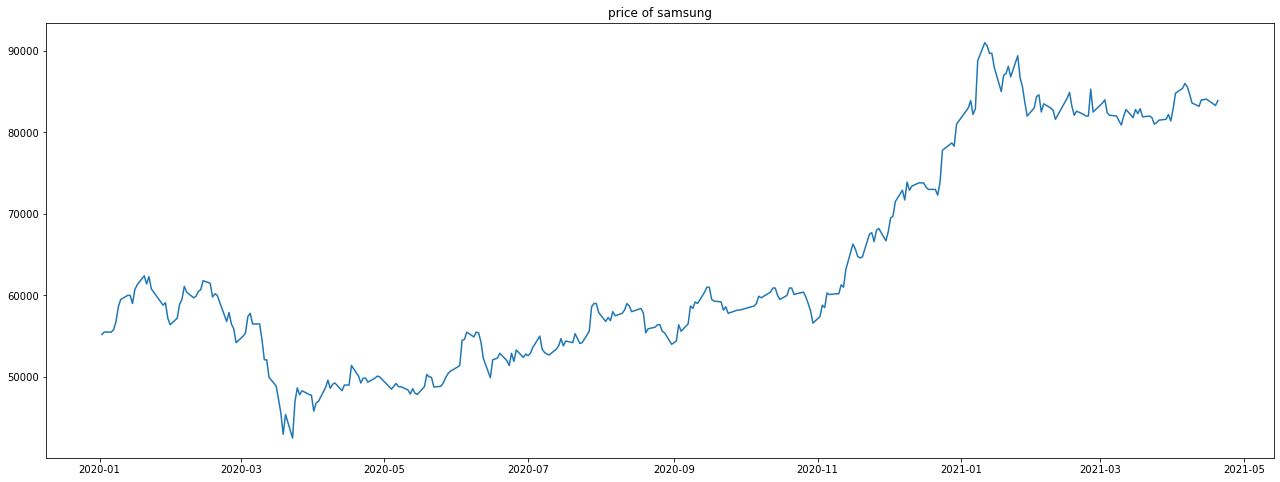

In [34]:
plt.figure(figsize = (22,8))
plt.plot(samsung_df.index, samsung_df.price)
plt.title("price of samsung")
plt.show()

위 그림으로 보았을 때는 데이터의 trend나 seasonal 한 부분을 파악하는게 어렵다.

시계열 분해법으로 분석해보자

In [74]:
df = pd.DataFrame({'price': samsung_df['price']})
start_date = '2020-01-02'
end_date = '2021-04-20'
index = pd.date_range(start_date, end_date, freq='B')
index = index[:322]
df.set_index(index, inplace=True)

<Figure size 432x288 with 0 Axes>

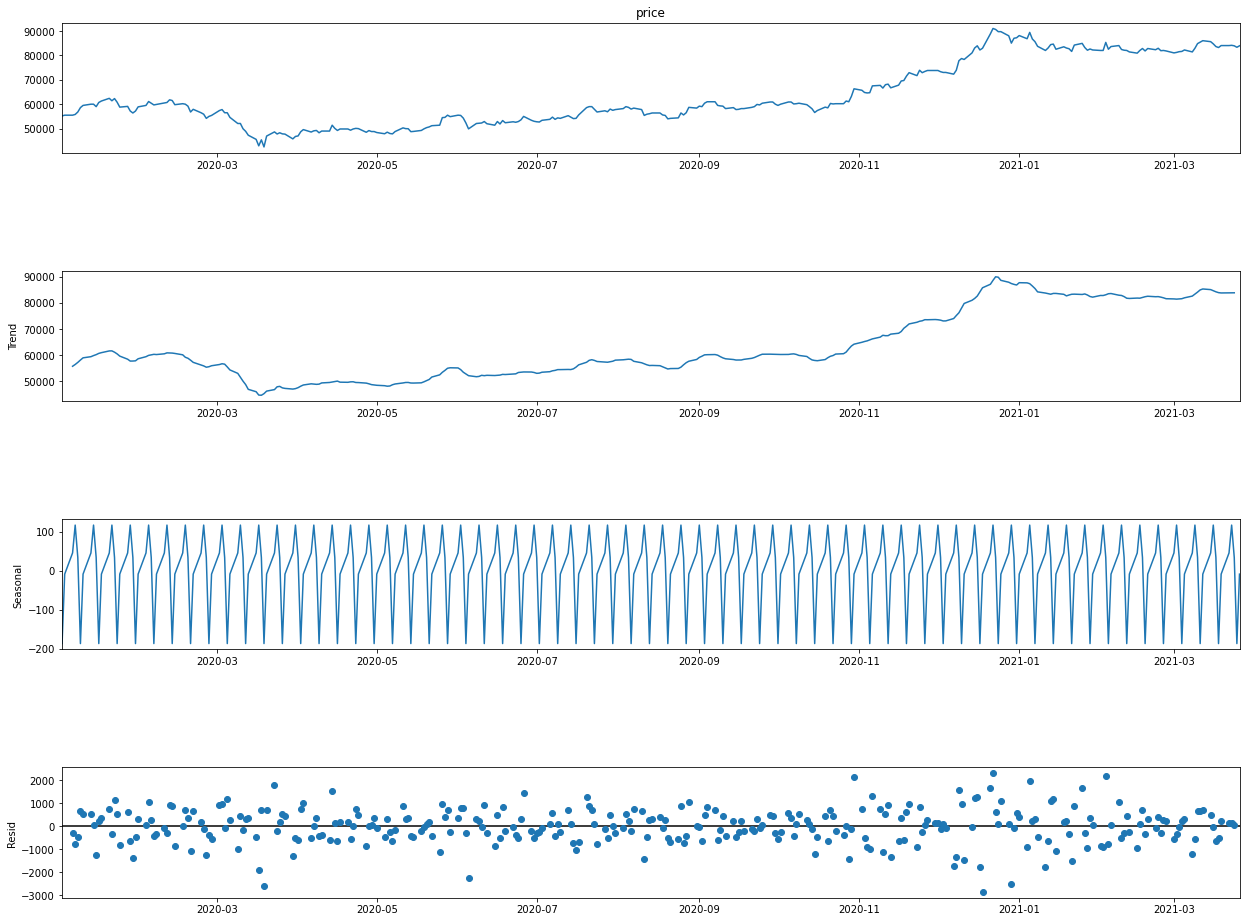

In [77]:
result = seasonal_decompose(df['price'], model='additive')

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

ACF를 그려 정상성이 있는지 파악하자

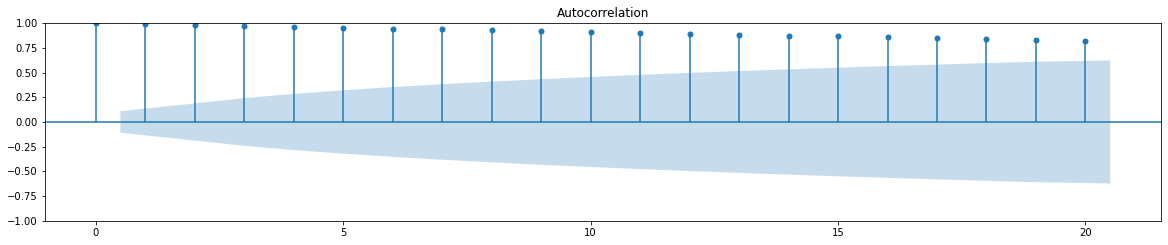

In [80]:
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df, lags=20, ax = ax1)

아주 천천히 값이 작아지는 것을 확인할 수 있다.

ACF값이 천천히 작아지는 것은 정상성을 만족하지 않는다는 것을 의미한다.

이번에는 ADF검정으로 정상성을 확인해보자.
- H0(귀무가설) : 자료에 단위근이 존재한다. 즉, 정상성을 만족하지 않는다.
- H1(대립가설) : 자료가 정상성을 만족한다.

In [84]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df)
print(f"ADF Statistic : {result[0]}")
print(f"p-value : {result[1]}")
print("Critical Values : ")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -0.21218947966329185
p-value : 0.9370529809409829
Critical Values : 
	1%: -3.451
	5%: -2.871
	10%: -2.572


p-value가 0.05를 넘기 때문에 귀무가설이 성립한다고 볼 수 있다.

즉, 위 시계열 데이터는 정상 시계열이라 보기 힘들다. 
<dl>
이를 해결해주기 위해 1차 차분을 해주었다.

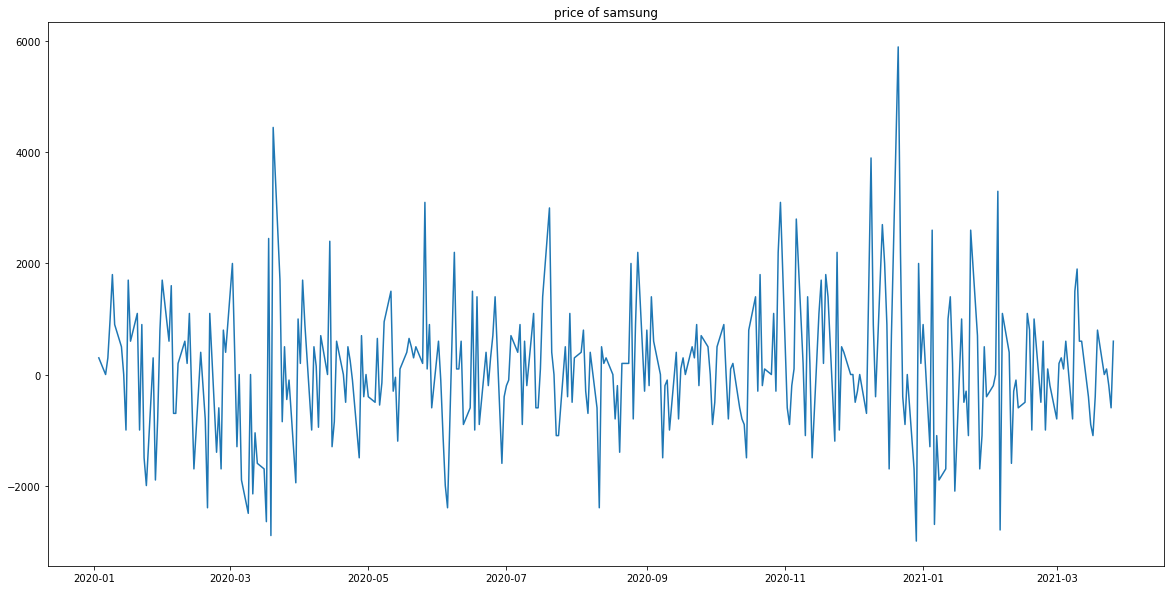

In [86]:
df_diff = df - df.shift()

plt.figure(figsize = (20,10))
plt.plot(df_diff)
plt.title("price of samsung")
plt.show()

이제는 일정한 패턴이 확인되지 않고, 정상성을 만족하는 것처럼 보인다.

ADF 검정 결과는 다음과 같다.

In [89]:
result = adfuller(df_diff[1:])
print(f"ADF Statistic : {result[0]}")
print(f"p-value : {result[1]}")
print("Critical Values : ")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -17.602795089961848
p-value : 3.913882166016894e-30
Critical Values : 
	1%: -3.451
	5%: -2.871
	10%: -2.572


p-value가 0.05 보다 작기 때문에 귀무가설을 기각함을 보인다.

즉, 1차 차분한 데이터는 정상성을 만족한다고 보인다.

---
이제는 데이터를 차분하여 정상성을 만족하게 되었으니, 이번에는 ACF와 PACF 그래프를 그려 ARIMA 모형의 p와 q를 결정하자.

C:\Users\smcho\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


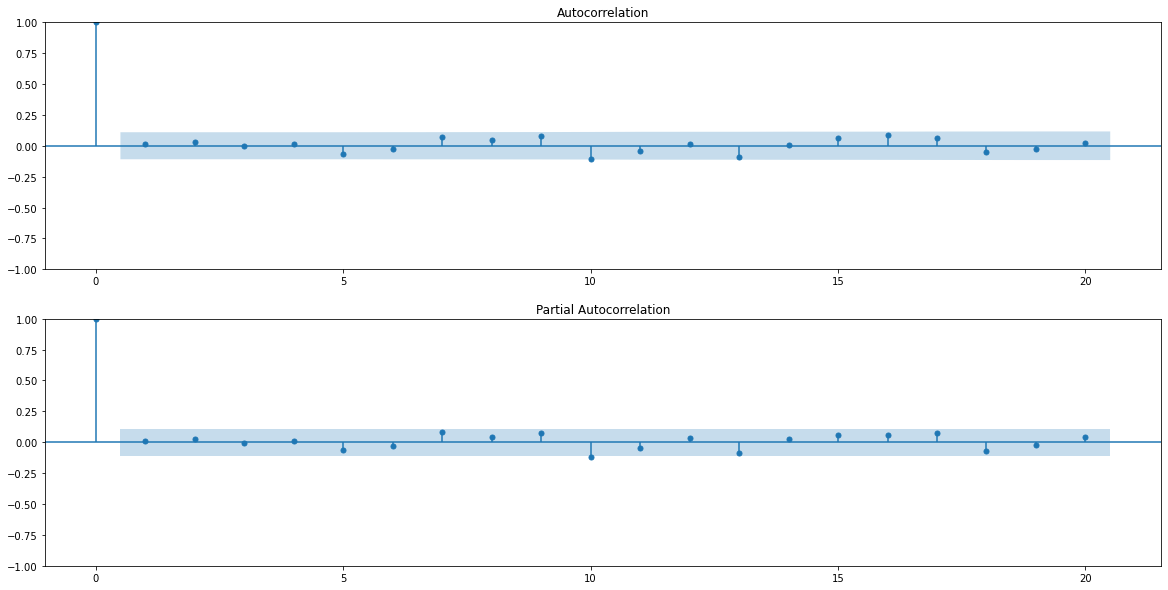

In [96]:
import statsmodels.api as sm

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff[1:], lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff[1:], lags=20, ax=ax2)

ACF와 PACF 모두 빠르게 0에 수렴하는 것을 볼 수 있다. 

2번째 lag 이후 0에 수렴하기 때문에 가장 좋은 모델은 ARIMA(2,1,2)로 보인다.

- ARIMA(2,1,2)

In [142]:
train_data = df[:len(df)-30]
test_data = df[len(df)-30:]

In [143]:
arima_model = SARIMAX(train_data['price'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

C:\Users\smcho\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      price   No. Observations:                  292
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -2485.436
Date:                                    Tue, 14 Mar 2023   AIC                           4992.872
Time:                                            18:38:58   BIC                           5033.278
Sample:                                        01-02-2020   HQIC                          5009.059
                                             - 02-12-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8723      0.257      3.396      0.001       0.369       1.376
ar.L2          0.0091      0.056      0.161      0.872      -0.102       0.120
ma.L1         -0.8629      0.249     -3.464      0.001      -1.351      -0.375
ar.S.L12       0.7991      0.211      3.791      0.000       0.386       1.212
ar.S.L24      -0.7757      0.131     -5.914      0.000      -1.033      -0.519
ar.S.L36       0.9727      0.078     12.430      0.000       0.819       1.126
ar.S.L48      -0.0124      0.052     -0.237      0.813      -0.115       0.090
ma.S.L12      -0.7932      0.226     -3.515      0.000      -1.236      -0.351
ma.S.L24       0.8092      0.169      4.781      0.000       0.477       1.141
ma.S.L36      -0.9764      0.123     -7.943      0.000      -1.217      -0.735
sigma2      1.607e+06   2.21e-07   7.26e+12      0.000    1.61e+06    1.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.30
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.41
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+31. Standard errors may be unstable.
"""

In [144]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-02-15    81465.184076
2021-02-16    81639.398788
2021-02-17    81607.345669
2021-02-18    81533.515774
2021-02-19    81619.950671
2021-02-22    81591.251285
2021-02-23    81424.150954
2021-02-24    81452.987638
2021-02-25    82474.667827
2021-02-26    82360.624683
2021-03-01    82269.031599
2021-03-02    82170.770839
2021-03-03    82173.180039
2021-03-04    82374.008329
2021-03-05    82459.668507
2021-03-08    82440.990657
2021-03-09    82759.850927
2021-03-10    82789.395316
2021-03-11    82822.211346
2021-03-12    82771.147710
2021-03-15    83311.610342
2021-03-16    83207.033768
2021-03-17    83024.138913
2021-03-18    82989.020587
2021-03-19    83079.933331
2021-03-22    83222.570643
2021-03-23    83183.657827
2021-03-24    83259.965850
2021-03-25    83534.757930
2021-03-26    83600.927838
Freq: B, Name: ARIMA Predictions, dtype: float64

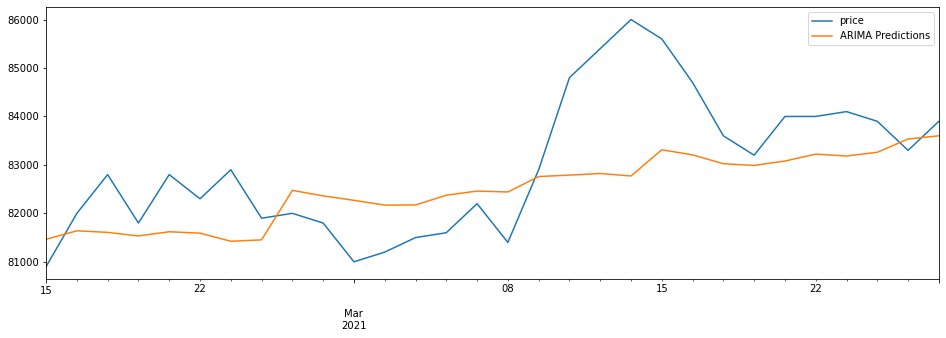

In [145]:
test_data['price'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);